In [246]:
import cv2
import os
import json
import time
import copy
import numpy as np
from matplotlib import pyplot as plt
from cpd_auto import cpd_auto
from moviepy.editor import VideoFileClip, concatenate_videoclips

In [350]:
percentage_selected = 0.25
number_of_segments = 50

In [351]:
#kts implemented

with open("./TestingData.json", 'r') as f:
    input_data = json.load(f)

processed_data_container = []

num = 1
for vid in range(len(input_data)):
    processed_data = []
    for i in range(len(input_data[vid]["clips"])):
        processed_data.append(input_data[vid]["clips"][i]['features'])
    

    X = copy.copy(processed_data)

    K = np.dot(np.array(processed_data), np.array(processed_data).T)
    processed_data = cpd_auto(K, number_of_segments, 1)

    mi = np.min(X)
    ma = np.max(X)
    # for cp in processed_data[0]:
    #     plt.plot([cp, cp], [mi, ma], 'r')
    # plt.show()
    
    processed_data_container.append({"video": input_data[vid]['video'],"stop_frames" : [0]+[input_data[vid]["clips"][int(i)]["segment"][0] for i in processed_data[0]], "stop_segments": [0] + [int(i) for i in processed_data[0]] + [len(input_data[vid]["clips"])]})

    print(f"video number {num} is done")
    num += 1


for vid in range(len(processed_data_container)):
    vid_frames = cv2.VideoCapture(f"../videos/tvsum/video/{processed_data_container[vid]['video']}").get(cv2.CAP_PROP_FRAME_COUNT)
    if processed_data_container[vid]['stop_frames'][-1] >= vid_frames:
        processed_data_container[vid]['stop_frames'][-1] = int(vid_frames) - 1
    else:
        processed_data_container[vid]['stop_frames'].append(int(vid_frames) - 1)
        
print(processed_data_container)

with open('array_data.json', 'w') as json_file:
    json.dump(processed_data_container, json_file, indent=4)

Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
video number 1 is done
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
video number 2 is done
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
video number 3 is done
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
video number 4 is done
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
video number 5 is done
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
video number 6 is done
Precomputing scatters...
Inferring best change points...
Precomputing scatters...
Inferring best change points...
video number 7 is done
Precomputing scatters...
Inferring best c

In [352]:
# average importance of segments calculations

with open("./KTS-input.json", 'r') as f_segment:
    input_data_segments = json.load(f_segment)
    # input_data[vid]["clips"][i]['features'] {"gzDbaEs1Rlg.mp4": [[[1, 15], 1.0, 1.3311079740524292]
av_seg_score = {}
av_seg_score_gt = {}
tmp = []
tmp_gt = []
for vid in processed_data_container:
    tmp = [i[2] for i in input_data_segments[vid['video']]]
    tmp_gt = [i[1] for i in input_data_segments[vid['video']]]
    av_seg_score[vid['video']] = []
    av_seg_score_gt[vid['video']] = []
    for i in range(len(vid['stop_segments'])-1):
        av_seg_score[vid['video']].append([[vid['stop_frames'][i], vid['stop_frames'][i+1]],
                                      sum(tmp[vid['stop_segments'][i]:vid['stop_segments'][i+1]]) / (vid['stop_segments'][i+1] - vid['stop_segments'][i])])  
        av_seg_score_gt[vid['video']].append([[vid['stop_frames'][i], vid['stop_frames'][i+1]],
                                              sum(tmp_gt[vid['stop_segments'][i]:vid['stop_segments'][i+1]]) / (vid['stop_segments'][i+1] - vid['stop_segments'][i])])

with open('av_score_seg_data.json', 'w') as json_file:
    json.dump(av_seg_score, json_file, indent=4)

with open('av_score_seg_data_gt.json', 'w') as json_file:
    json.dump(av_seg_score_gt, json_file, indent=4)
    

In [353]:
# optimal frames to form the video

def fractional_knapsack(segments, importances, max_frames):
    # Calculate the value-to-weight ratio for each segment
    value_per_weight = [(importance / (end - start + 1), start, end) for (start, end), importance in zip(segments, importances)]
    
    # Sort the segments based on the value-to-weight ratio in descending order
    value_per_weight.sort(reverse=True, key=lambda x: x[0])
    
    total_value = 0
    selected_segments = []
    values = []
    remaining_frames = max_frames
    
    for value_weight, start, end in value_per_weight:
        if remaining_frames == 0:
            break
        
        frames = min(end - start + 1, remaining_frames)
        value = value_weight * frames
        
        total_value += value
        selected_segments.append((start, start + frames - 1))
        values.append(value)
        
        remaining_frames -= frames
    
    return selected_segments, values

def optimize_segments(input_file, output_file):
    outputs = {}
    with open(input_file, 'r') as f_segment:
        inputs = json.load(f_segment)
        for key in inputs.keys():
            segments = [inputs[key][i][0] for i in range(len(inputs[key]))]
            importances = [inputs[key][i][1] for i in range(len(inputs[key]))]
            max_num_frames = segments[-1][-1] * percentage_selected
            selected_segments, values = fractional_knapsack(segments, importances, max_num_frames)
            selected_segments = [[[selected_segments[i][0], selected_segments[i][1]], values[i]] for i in range(len(selected_segments))]   # [[start, finish], value]
            selected_segments.sort(key=lambda x: x[0][0])   
            outputs[key] = selected_segments
        with open(output_file, 'w') as json_file:
            json.dump(outputs, json_file, indent=4)

optimize_segments('av_score_seg_data.json', 'selected_frames_with_importance.json')
optimize_segments('av_score_seg_data_gt.json', 'selected_frames_with_importance_gt.json')

In [356]:
# generates summary video with sound

def extract_segments(input_video_path, segments, output_path, output_video_name):
    # Check if the input video file exists
    if not os.path.exists(input_video_path):
        print(f"Error: The video file {input_video_path} does not exist.")
        return
    
    # Load the video using moviepy
    video = VideoFileClip(input_video_path)
    
    # Extract the segments
    clips = []
    for start_frame, end_frame in segments:
        start_time = start_frame / video.fps
        end_time = end_frame / video.fps
        clip = video.subclip(start_time, end_time)
        clips.append(clip)
    
    # Concatenate the segments
    final_clip = concatenate_videoclips(clips)
    
    # Ensure the output directory exists
    if not os.path.exists(output_path):
        os.makedirs(output_path)
    
    # Define the output video path
    output_video_path = os.path.join(output_path, output_video_name)
    
    # Write the output video file with audio
    final_clip.write_videofile(output_video_path, codec='libx264', audio_codec='aac')

    print(f"Segments have been extracted and combined into {output_video_path}")


# Example usage
input_dir = '../videos/tvsum/video'
output_dir = './output_files_with_sound'


try:
    with open("./selected_frames_with_importance.json", 'r') as f_segment:
        inputs = json.load(f_segment)
        for key in inputs.keys():
            segments = [[int(inputs[key][i][0][0]), int(inputs[key][i][0][1])] for i in range(len(inputs[key]))]
            video_path = os.path.join(input_dir, f"{key}")

            extract_segments(video_path, segments, output_dir, f"{key[:-4]}_out.mp4")
except:
    print(f"Video {key} does not have prediction data.")

try:
    with open("./selected_frames_with_importance_gt.json", 'r') as f_segment:
        inputs = json.load(f_segment)
        for key in inputs.keys():
            segments = [[int(inputs[key][i][0][0]), int(inputs[key][i][0][1])] for i in range(len(inputs[key]))]
            video_path = os.path.join(input_dir, f"{key}")

            extract_segments(video_path, segments, output_dir, f"{key[:-4]}_out_gt.mp4")
except:
    print(f"Video {key} GT does not have ground truth data.")


t:  13%|█▎        | 354/2829 [04:54<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\gzDbaEs1Rlg_out.mp4.
MoviePy - Writing audio in gzDbaEs1Rlg_outTEMP_MPY_wvf_snd.mp4





















t:  13%|█▎        | 354/2829 [04:56<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\gzDbaEs1Rlg_out.mp4




























































t:  13%|█▎        | 354/2829 [05:04<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\gzDbaEs1Rlg_out.mp4
Segments have been extracted and combined into ./output_files_with_sound\gzDbaEs1Rlg_out.mp4



t:  13%|█▎        | 354/2829 [05:08<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\jcoYJXDG9sw_out.mp4.
MoviePy - Writing audio in jcoYJXDG9sw_outTEMP_MPY_wvf_snd.mp4



















t:  13%|█▎        | 354/2829 [05:09<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\jcoYJXDG9sw_out.mp4


























































t:  13%|█▎        | 354/2829 [05:17<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\jcoYJXDG9sw_out.mp4
Segments have been extracted and combined into ./output_files_with_sound\jcoYJXDG9sw_out.mp4



t:  13%|█▎        | 354/2829 [05:21<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\oDXZc0tZe04_out.mp4.
MoviePy - Writing audio in oDXZc0tZe04_outTEMP_MPY_wvf_snd.mp4


























t:  13%|█▎        | 354/2829 [05:23<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\oDXZc0tZe04_out.mp4



















































































































t:  13%|█▎        | 354/2829 [05:38<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\oDXZc0tZe04_out.mp4
Segments have been extracted and combined into ./output_files_with_sound\oDXZc0tZe04_out.mp4



t:  13%|█▎        | 354/2829 [05:41<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\PJrm840pAUI_out.mp4.
MoviePy - Writing audio in PJrm840pAUI_outTEMP_MPY_wvf_snd.mp4






















t:  13%|█▎        | 354/2829 [05:43<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\PJrm840pAUI_out.mp4












































































t:  13%|█▎        | 354/2829 [05:53<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\PJrm840pAUI_out.mp4
Segments have been extracted and combined into ./output_files_with_sound\PJrm840pAUI_out.mp4



t:  13%|█▎        | 354/2829 [05:56<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\EYqVtI9YWJA_out.mp4.
MoviePy - Writing audio in EYqVtI9YWJA_outTEMP_MPY_wvf_snd.mp4


















t:  13%|█▎        | 354/2829 [05:57<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\EYqVtI9YWJA_out.mp4


























































t:  13%|█▎        | 354/2829 [06:06<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\EYqVtI9YWJA_out.mp4
Segments have been extracted and combined into ./output_files_with_sound\EYqVtI9YWJA_out.mp4



t:  13%|█▎        | 354/2829 [06:08<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\37rzWOQsNIw_out.mp4.
MoviePy - Writing audio in 37rzWOQsNIw_outTEMP_MPY_wvf_snd.mp4
















t:  13%|█▎        | 354/2829 [06:10<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\37rzWOQsNIw_out.mp4





















































t:  13%|█▎        | 354/2829 [06:17<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\37rzWOQsNIw_out.mp4
Segments have been extracted and combined into ./output_files_with_sound\37rzWOQsNIw_out.mp4



t:  13%|█▎        | 354/2829 [06:21<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\JgHubY5Vw3Y_out.mp4.
MoviePy - Writing audio in JgHubY5Vw3Y_outTEMP_MPY_wvf_snd.mp4














t:  13%|█▎        | 354/2829 [06:22<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\JgHubY5Vw3Y_out.mp4







































t:  13%|█▎        | 354/2829 [06:27<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\JgHubY5Vw3Y_out.mp4
Segments have been extracted and combined into ./output_files_with_sound\JgHubY5Vw3Y_out.mp4



t:  13%|█▎        | 354/2829 [06:31<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\z_6gVvQb2d0_out.mp4.
MoviePy - Writing audio in z_6gVvQb2d0_outTEMP_MPY_wvf_snd.mp4



















t:  13%|█▎        | 354/2829 [06:32<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\z_6gVvQb2d0_out.mp4





















































































t:  13%|█▎        | 354/2829 [06:43<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\z_6gVvQb2d0_out.mp4
Segments have been extracted and combined into ./output_files_with_sound\z_6gVvQb2d0_out.mp4



t:  13%|█▎        | 354/2829 [06:47<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\J0nA4VgnoCo_out.mp4.
MoviePy - Writing audio in J0nA4VgnoCo_outTEMP_MPY_wvf_snd.mp4








































t:  13%|█▎        | 354/2829 [06:52<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\J0nA4VgnoCo_out.mp4



Video J0nA4VgnoCo.mp4 does not have prediction data.



t:  13%|█▎        | 354/2829 [07:13<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\gzDbaEs1Rlg_out_gt.mp4.
MoviePy - Writing audio in gzDbaEs1Rlg_out_gtTEMP_MPY_wvf_snd.mp4


























t:  13%|█▎        | 354/2829 [07:16<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\gzDbaEs1Rlg_out_gt.mp4

































































t:  13%|█▎        | 354/2829 [07:24<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\gzDbaEs1Rlg_out_gt.mp4
Segments have been extracted and combined into ./output_files_with_sound\gzDbaEs1Rlg_out_gt.mp4



t:  13%|█▎        | 354/2829 [07:27<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\jcoYJXDG9sw_out_gt.mp4.
MoviePy - Writing audio in jcoYJXDG9sw_out_gtTEMP_MPY_wvf_snd.mp4

















t:  13%|█▎        | 354/2829 [07:29<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\jcoYJXDG9sw_out_gt.mp4

























































t:  13%|█▎        | 354/2829 [07:36<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\jcoYJXDG9sw_out_gt.mp4
Segments have been extracted and combined into ./output_files_with_sound\jcoYJXDG9sw_out_gt.mp4



t:  13%|█▎        | 354/2829 [07:43<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\oDXZc0tZe04_out_gt.mp4.
MoviePy - Writing audio in oDXZc0tZe04_out_gtTEMP_MPY_wvf_snd.mp4














































t:  13%|█▎        | 354/2829 [07:49<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\oDXZc0tZe04_out_gt.mp4





















































































































































































t:  13%|█▎        | 354/2829 [08:14<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\oDXZc0tZe04_out_gt.mp4
Segments have been extracted and combined into ./output_files_with_sound\oDXZc0tZe04_out_gt.mp4



t:  13%|█▎        | 354/2829 [08:17<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\PJrm840pAUI_out_gt.mp4.
MoviePy - Writing audio in PJrm840pAUI_out_gtTEMP_MPY_wvf_snd.mp4




















t:  13%|█▎        | 354/2829 [08:19<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\PJrm840pAUI_out_gt.mp4








































































t:  13%|█▎        | 354/2829 [08:28<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\PJrm840pAUI_out_gt.mp4
Segments have been extracted and combined into ./output_files_with_sound\PJrm840pAUI_out_gt.mp4



t:  13%|█▎        | 354/2829 [08:31<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\EYqVtI9YWJA_out_gt.mp4.
MoviePy - Writing audio in EYqVtI9YWJA_out_gtTEMP_MPY_wvf_snd.mp4


















t:  13%|█▎        | 354/2829 [08:33<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\EYqVtI9YWJA_out_gt.mp4




























































t:  13%|█▎        | 354/2829 [08:41<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\EYqVtI9YWJA_out_gt.mp4
Segments have been extracted and combined into ./output_files_with_sound\EYqVtI9YWJA_out_gt.mp4



t:  13%|█▎        | 354/2829 [08:44<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\37rzWOQsNIw_out_gt.mp4.
MoviePy - Writing audio in 37rzWOQsNIw_out_gtTEMP_MPY_wvf_snd.mp4




















t:  13%|█▎        | 354/2829 [08:46<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\37rzWOQsNIw_out_gt.mp4



































































t:  13%|█▎        | 354/2829 [08:54<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\37rzWOQsNIw_out_gt.mp4
Segments have been extracted and combined into ./output_files_with_sound\37rzWOQsNIw_out_gt.mp4



t:  13%|█▎        | 354/2829 [08:59<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\JgHubY5Vw3Y_out_gt.mp4.
MoviePy - Writing audio in JgHubY5Vw3Y_out_gtTEMP_MPY_wvf_snd.mp4















t:  13%|█▎        | 354/2829 [09:00<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\JgHubY5Vw3Y_out_gt.mp4

















































t:  13%|█▎        | 354/2829 [09:07<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\JgHubY5Vw3Y_out_gt.mp4
Segments have been extracted and combined into ./output_files_with_sound\JgHubY5Vw3Y_out_gt.mp4



t:  13%|█▎        | 354/2829 [09:11<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\z_6gVvQb2d0_out_gt.mp4.
MoviePy - Writing audio in z_6gVvQb2d0_out_gtTEMP_MPY_wvf_snd.mp4




















t:  13%|█▎        | 354/2829 [09:13<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\z_6gVvQb2d0_out_gt.mp4























































































t:  13%|█▎        | 354/2829 [09:24<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\z_6gVvQb2d0_out_gt.mp4
Segments have been extracted and combined into ./output_files_with_sound\z_6gVvQb2d0_out_gt.mp4



t:  13%|█▎        | 354/2829 [09:28<00:11, 206.30it/s, now=None] 

Moviepy - Building video ./output_files_with_sound\J0nA4VgnoCo_out_gt.mp4.
MoviePy - Writing audio in J0nA4VgnoCo_out_gtTEMP_MPY_wvf_snd.mp4




































t:  13%|█▎        | 354/2829 [09:31<00:11, 206.30it/s, now=None] 

MoviePy - Done.
Moviepy - Writing video ./output_files_with_sound\J0nA4VgnoCo_out_gt.mp4














































































































































t:  13%|█▎        | 354/2829 [09:48<00:11, 206.30it/s, now=None] 

Moviepy - Done !
Moviepy - video ready ./output_files_with_sound\J0nA4VgnoCo_out_gt.mp4
Segments have been extracted and combined into ./output_files_with_sound\J0nA4VgnoCo_out_gt.mp4


In [357]:
#Calculate the F1 score
with open('selected_frames_with_importance.json', 'r') as f:
    selected_frames = json.load(f)
    
with open('selected_frames_with_importance_gt.json', 'r') as f:
    selected_frames_gt = json.load(f)
    
frames = []
for value in selected_frames.values():
    for v in value:
        frames.append(v[0])
        
frames_gt = []
for value in selected_frames_gt.values():
    for v in value:
        frames_gt.append(v[0])
        
frames_common = [frame for frame in frames if frame in frames_gt]

total = sum([i[1] - i[0] + 1 for i in frames])
total_gt = sum([i[1] - i[0] + 1 for i in frames_gt])
total_common = sum([i[1] - i[0] + 1 for i in frames_common])

precision = total_common / total
recall = total_common / total_gt

f1 = 2 * precision * recall / (precision + recall)

print(f"F1 score: {f1}")

F1 score: 0.569667823357475


In [358]:
#Calculate F1 score per video

f1_per_video = {}

for key in selected_frames.keys():
    frames = [v[0] for v in selected_frames[key]]
    frames_gt = [v[0] for v in selected_frames_gt[key]]
    frames_common = [frame for frame in frames if frame in frames_gt]
    
    total = sum([i[1] - i[0] + 1 for i in frames])
    total_gt = sum([i[1] - i[0] + 1 for i in frames_gt])
    total_common = sum([i[1] - i[0] + 1 for i in frames_common])
    
    precision = total_common / total
    recall = total_common / total_gt
    try:
        f1 = 2 * precision * recall / (precision + recall)
    except ZeroDivisionError:
        f1 = 0
    
    f1_per_video[key] = f1
    
for key, value in f1_per_video.items():
    print(f"{key}: {value}")

gzDbaEs1Rlg.mp4: 0.6308780690803163
jcoYJXDG9sw.mp4: 0.623785594639866
oDXZc0tZe04.mp4: 0.4619293787785858
PJrm840pAUI.mp4: 0.6955464356285149
EYqVtI9YWJA.mp4: 0.6702593465813406
37rzWOQsNIw.mp4: 0.7106775823027347
JgHubY5Vw3Y.mp4: 0.5661166627934
z_6gVvQb2d0.mp4: 0.5801932367149758
J0nA4VgnoCo.mp4: 0.38978456270509343


### 50 Scenes
- 10% : 0.5426
- 20% : 0.5799
- 30% : 0.6621
- 40% : 0.7077
- 50% : 0.7501

### 75 Scenes
- 10% : 0.5773
- 20% : 0.6652
- 30% : 0.6604
- 40% : 0.6935
- 50% : 0.7607

### 100 Scenes
- 10% : 0.6275
- 20% : 0.6563
- 30% : 0.6877
- 40% : 0.7209
- 50% : 0.7472

### 125 Scenes
- 10% : 0.5706
- 20% : 0.6998
- 30% : 0.7338
- 40% : 0.7291
- 50% : 0.7488

### 150 Scenes
- 10% : 0.5578
- 20% : 0.6858
- 30% : 0.7317
- 40% : 0.7842
- 50% : 0.7682

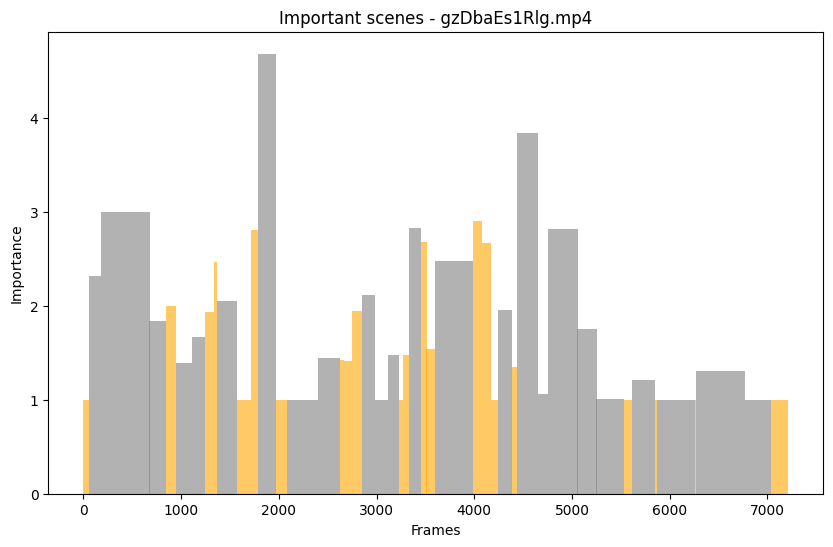

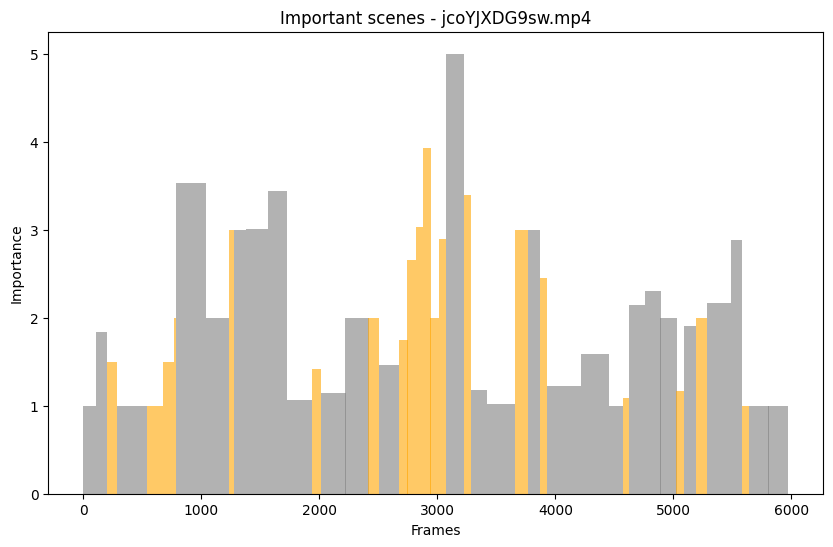

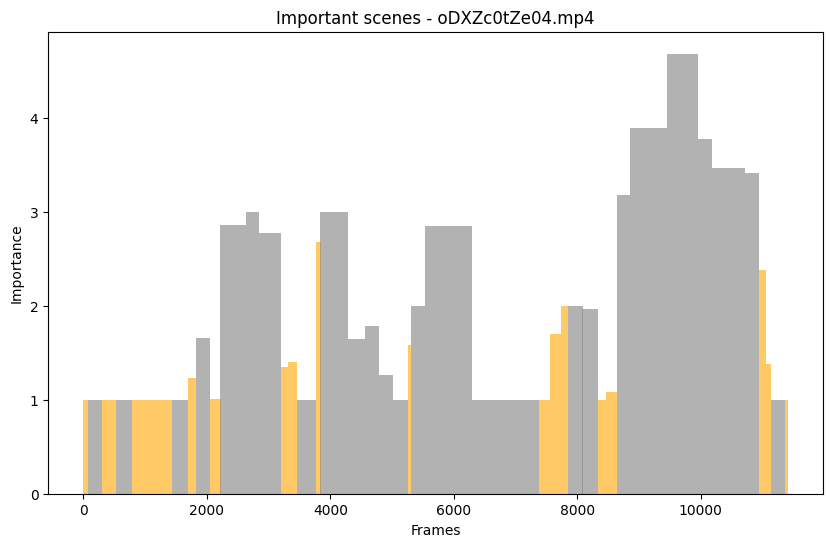

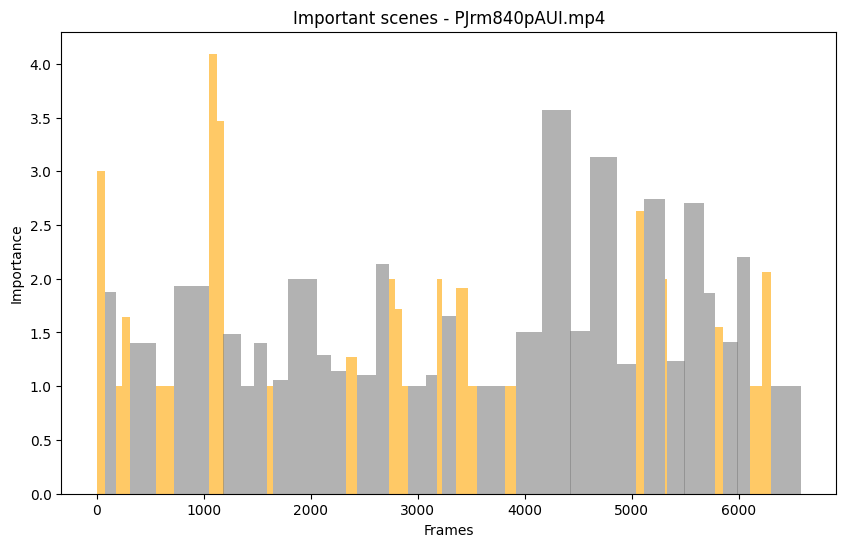

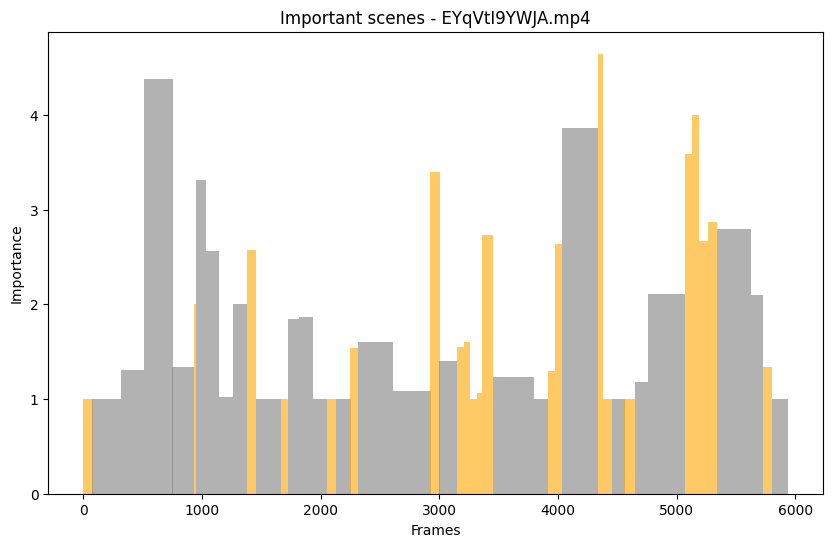

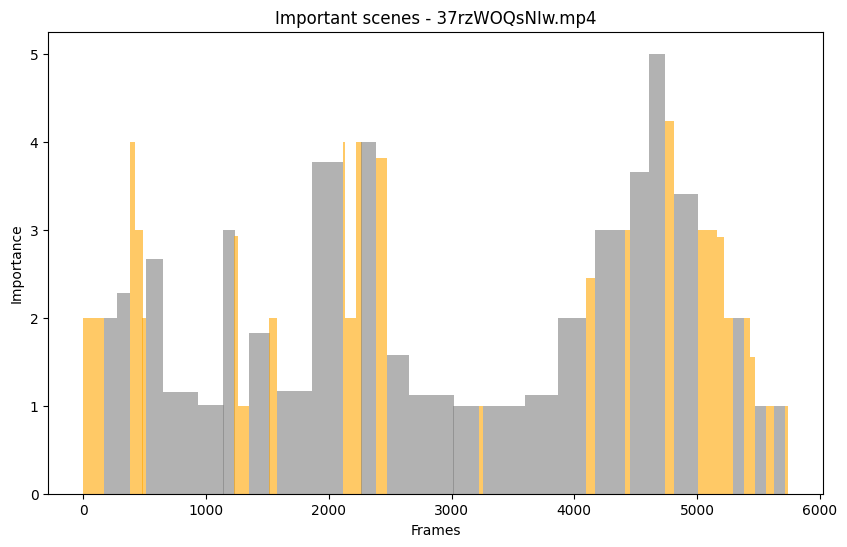

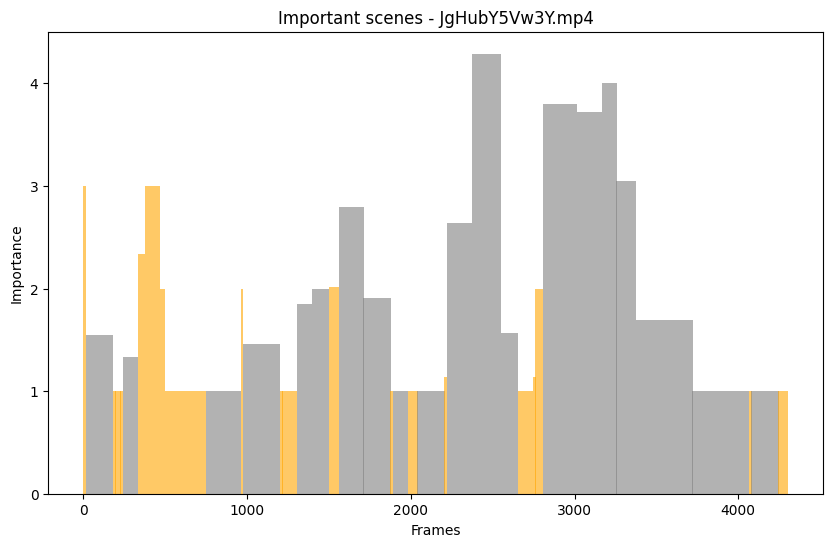

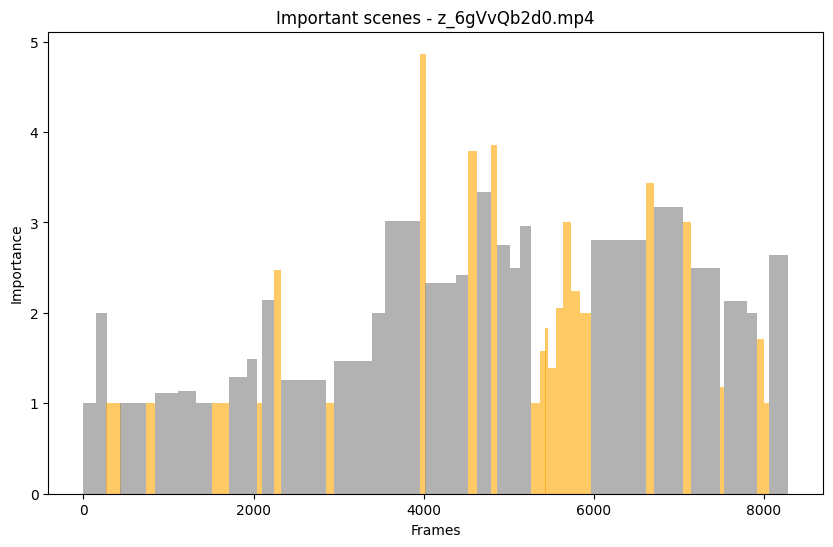

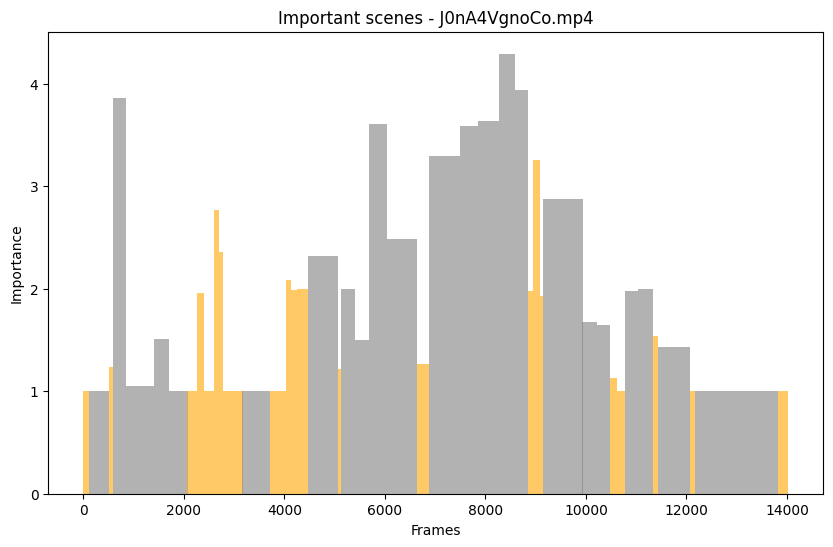

In [299]:
import json
import matplotlib.pyplot as plt

def plot_video_segments(video_name, segments, selected_segments, gt_segments):
    plt.figure(figsize=(10, 6))
    plt.title("Important scenes - " + video_name)
    plt.xlabel("Frames")
    plt.ylabel("Importance")

    min_importance = min(seg[1] for seg in segments) - 0.1

    for segment_indx in range(len(segments)):
        start, end = segments[segment_indx][0]
        importance = gt_segments[segment_indx][1]

        # Check if the segment exists in selected_segments
        exists = any(start == s[0][0] and end == s[0][1] for s in selected_segments)

        if exists:
            plt.bar(range(start, end+1), [importance], color='orange', alpha=0.6, label="Chosen", width=1.0)
        else:
            plt.bar(range(start, end+1), [importance], color='gray', alpha=0.6, label="Not chosen", width=1.0)


    plt.show()

# Read data from JSON files
with open('av_score_seg_data.json', 'r') as f1, open('selected_frames_with_importance.json', 'r') as f2, open('av_score_seg_data_gt.json', 'r') as f3:
    av_score_seg_data = json.load(f1)
    selected_frames_with_importance = json.load(f2)
    av_score_seg_data_gt = json.load(f3)

# Plot graphs for each video
for video_name, segments in av_score_seg_data.items():
    selected_segments = selected_frames_with_importance.get(video_name, [])
    gt_segments = av_score_seg_data_gt.get(video_name, [])
    plot_video_segments(video_name, segments, selected_segments, gt_segments)


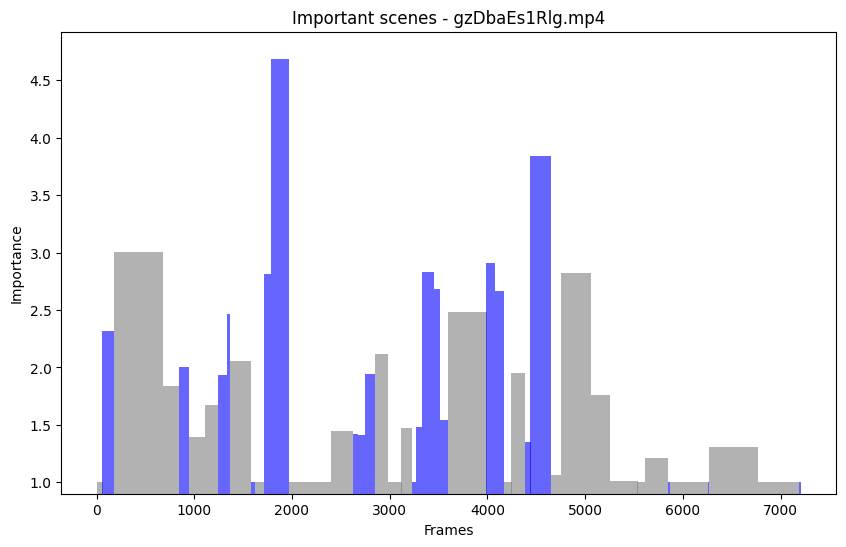

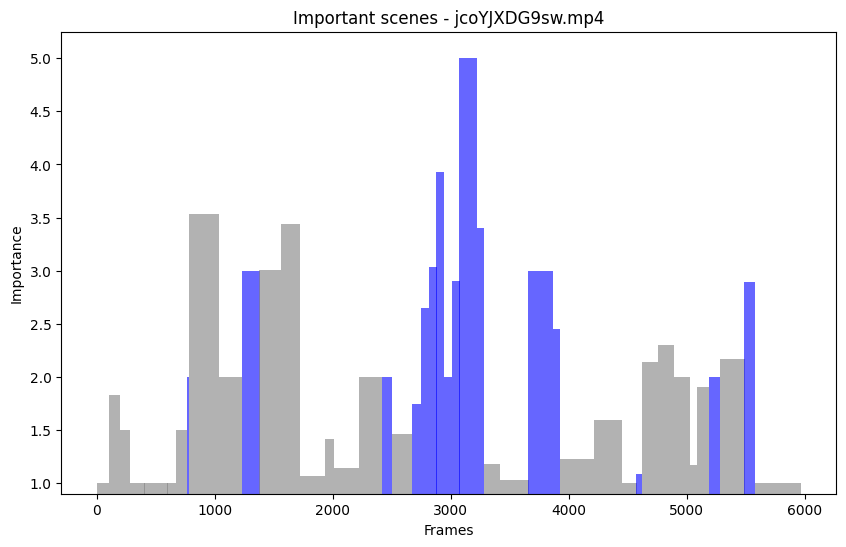

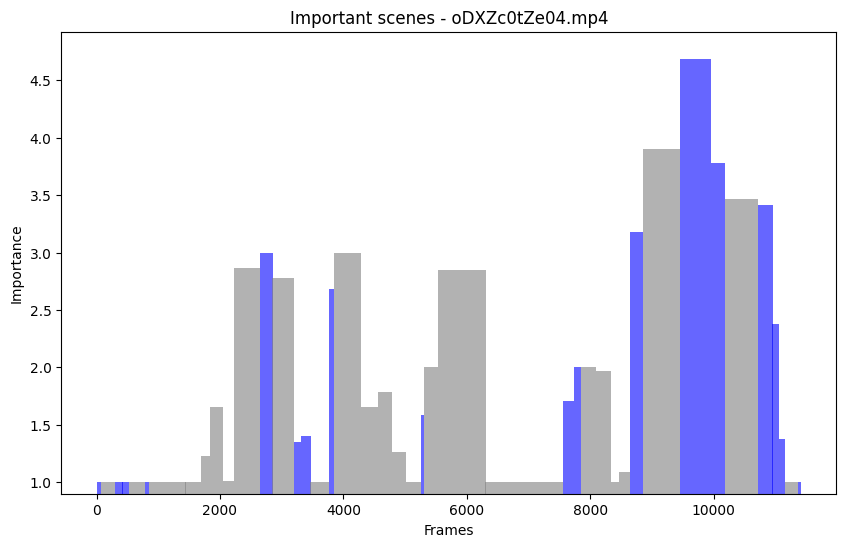

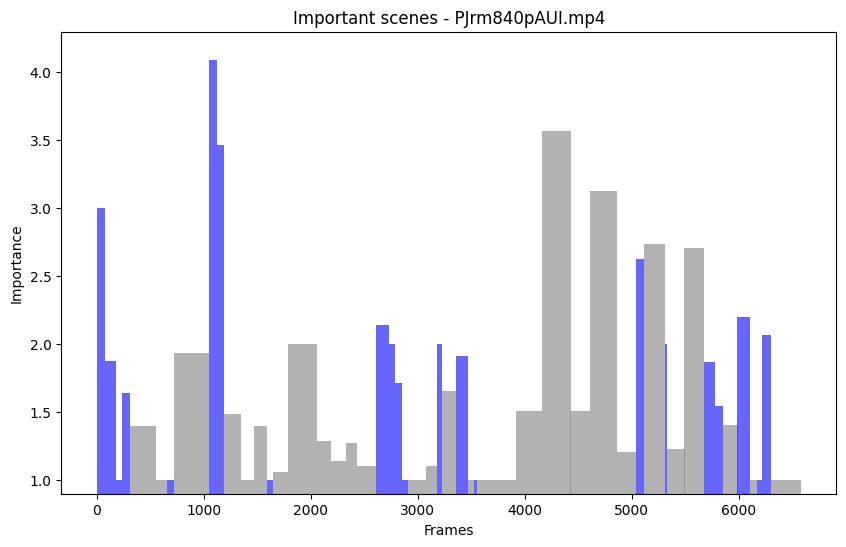

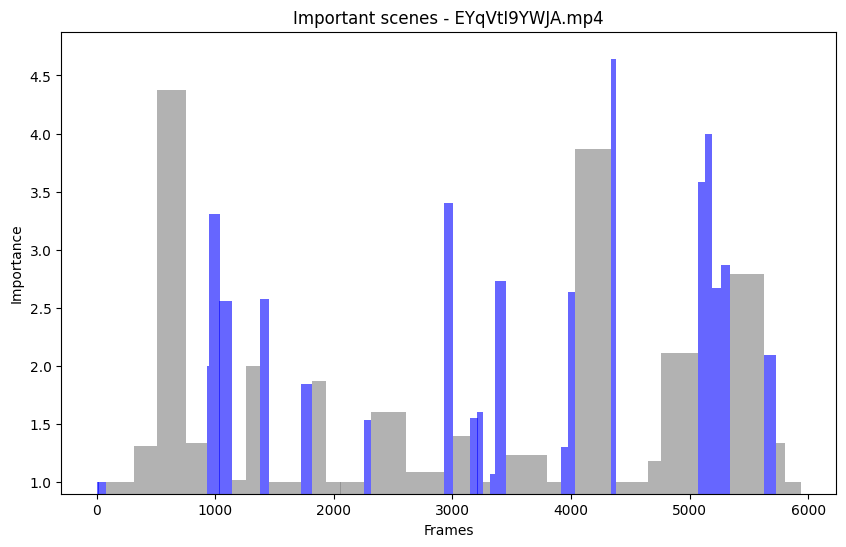

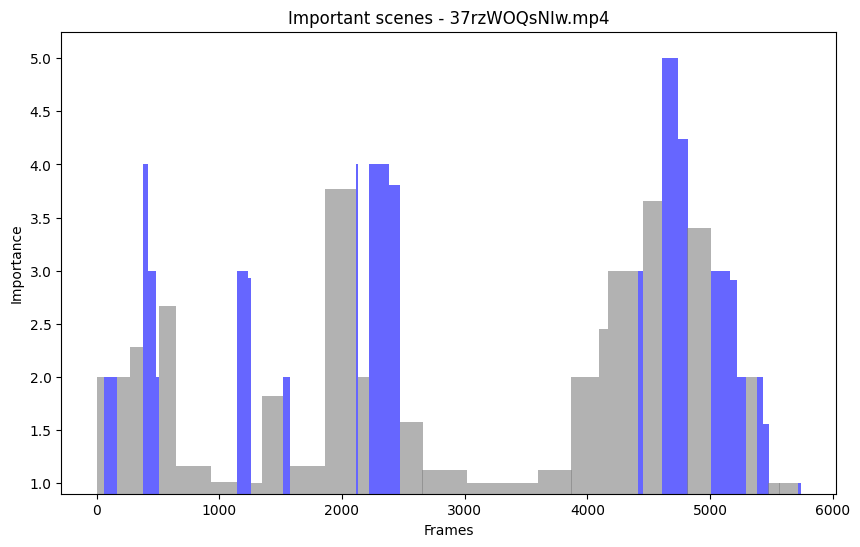

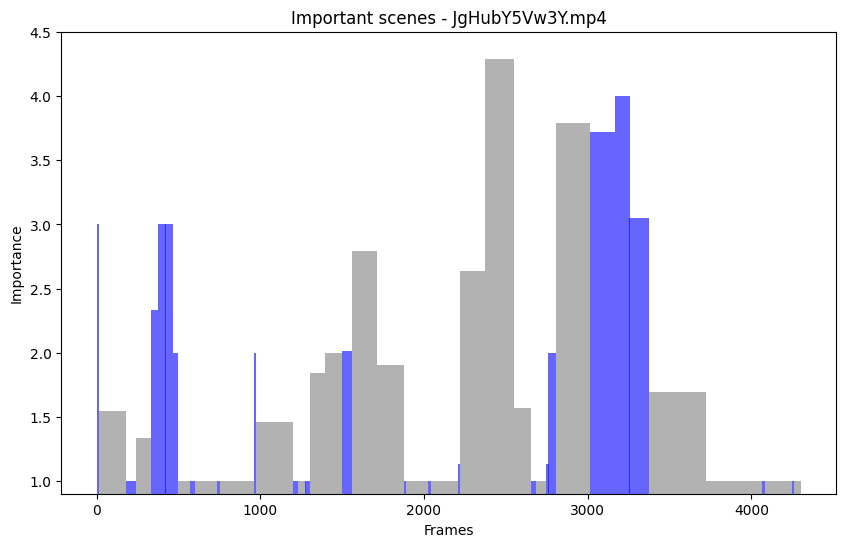

KeyboardInterrupt: 

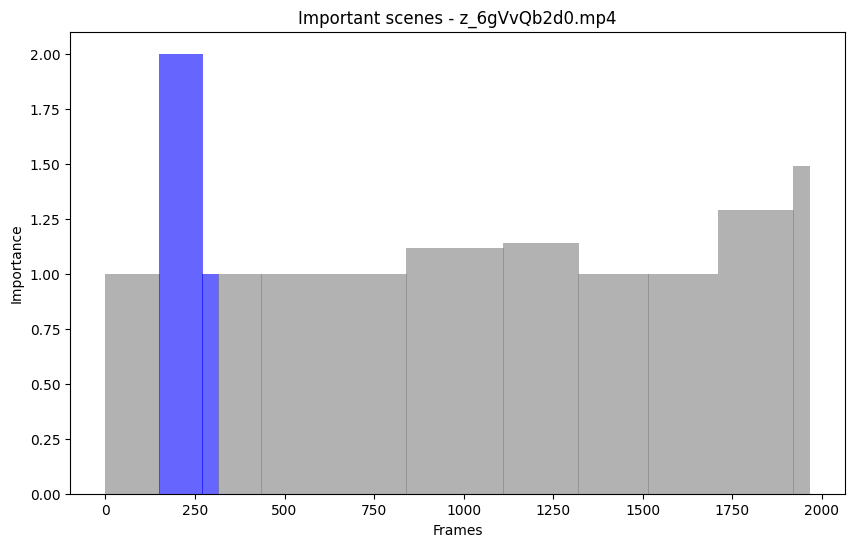

In [300]:
import json
import matplotlib.pyplot as plt

def plot_video_segments(video_name, segments, selected_segments):
    plt.figure(figsize=(10, 6))
    plt.title("Important scenes - " + video_name)
    plt.xlabel("Frames")
    plt.ylabel("Importance")

    min_importance = min(seg[1] for seg in segments) - 0.1

    for segment in segments:
        start, end = segment[0]
        importance = segment[1]

        # Check if the segment exists in selected_segments
        exists = any(start == s[0][0] and end == s[0][1] for s in selected_segments)

        if exists:
            plt.bar(range(start, end+1), [importance], color='blue', alpha=0.6, label="Chosen", width=1.0)
        else:
            plt.bar(range(start, end+1), [importance], color='gray', alpha=0.6, label="Not chosen", width=1.0)

    plt.ylim(bottom=min_importance)
    plt.show()

# Read data from JSON files
with open('av_score_seg_data_gt.json', 'r') as f1, open('selected_frames_with_importance_gt.json', 'r') as f2:
    av_score_seg_data = json.load(f1)
    selected_frames_with_importance = json.load(f2)

# Plot graphs for each video
for video_name, segments in av_score_seg_data.items():
    selected_segments = selected_frames_with_importance.get(video_name, [])
    plot_video_segments(video_name, segments, selected_segments)